<a href="https://colab.research.google.com/github/Sumalyo/MONN_work/blob/main/MONN_Simulations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

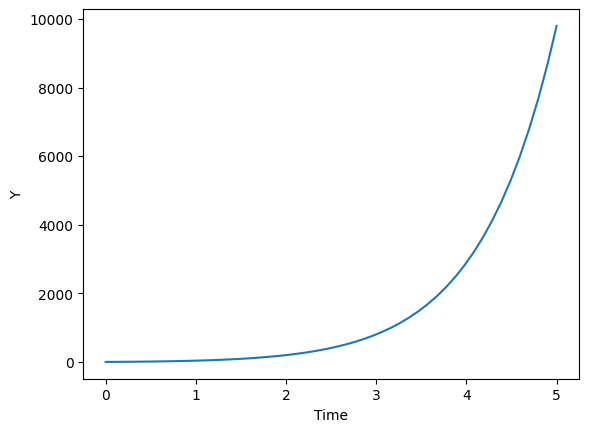

In [2]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial condition
y0 = 1

# Time points
t = np.linspace(0, 5)

# Define the differential equation using lambda
# dy/dt = -y * t + 13
dydt = lambda y, t: 13 * np.exp(t) + y

# Solve the ODE
y = odeint(dydt, y0, t)

plt.plot(t, y)
plt.xlabel("Time")
plt.ylabel("Y")
plt.show()

Starting simulation for 0.5 seconds...
Simulation finished. Plotting results.


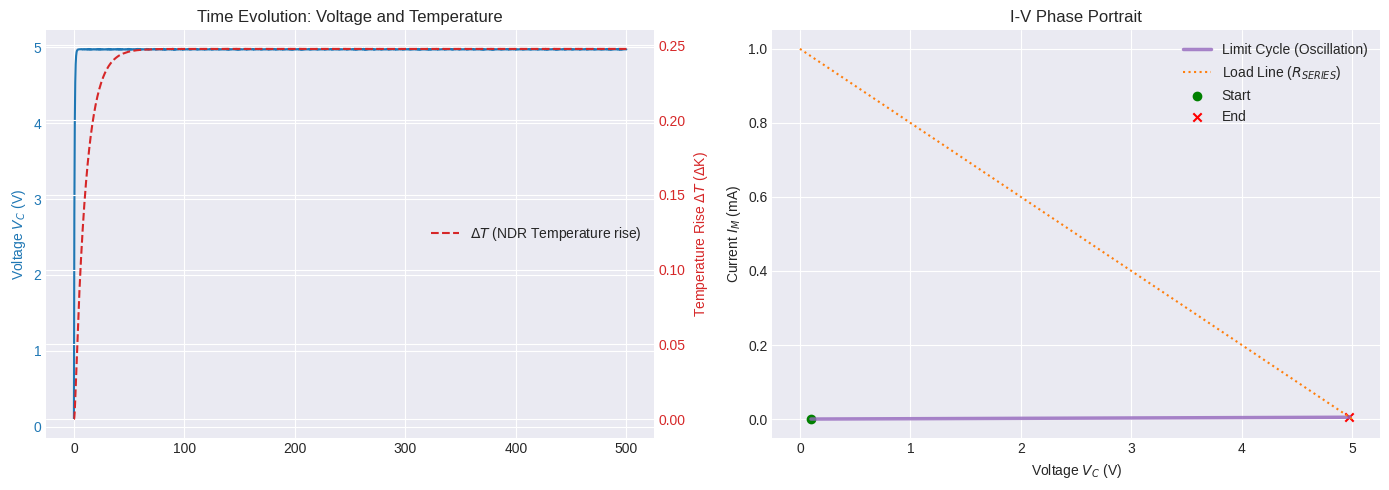


--- Simulation Summary ---
Final V_C range: 0.100 V to 4.981 V
Final T range: 300.0 K to 300.2 K (Delta T: 0.2 K)
NDR device must have an S-type characteristic for these parameters to oscillate.


In [4]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# --- 1. Circuit and Model Parameters ---

# Circuit parameters (External components)
V_BIAS = 5.0    # DC Supply Voltage (Volts)
R_SERIES = 5e3  # Series Load Resistor (Ohms). Must be large enough to enable NDR operation.
C_CAP = 100e-9  # External Capacitor (Farads). Provides the slow voltage dynamics.

# Thermal NDR Model Parameters (Device parameters)
T_AMB = 300.0   # Ambient Temperature (Kelvin)
C_TH = 1e-6     # Thermal Capacitance (J/K)
G_TH = 1e-4     # Thermal Conductance to ambient (W/K) (1/R_th)

# Electrical Conductance Parameters
# This model uses an Arrhenius-like temperature dependence for conductance,
# which is common for oxide-based threshold switches.
G_0 = 1e-6      # Low-temp (leakage) conductance (Siemens)
G_1 = 0.5e-3    # Factor for high-temp conductance (Siemens)
E_A = 0.4       # Activation Energy (eV) - determines sensitivity to temp
K_B = 8.617e-5  # Boltzmann Constant (eV/K)

# --- 2. Defining the System of ODEs (The Derivatives) ---

def electro_thermal_ndr_ode(t, Y):
    """
    Defines the system of two coupled ordinary differential equations (ODEs).

    The state vector Y = [V_C, T], where:
    V_C: Voltage across the capacitor (and NDR device)
    T: Temperature of the active region of the NDR device

    dY/dt = [dV_C/dt, dT/dt]

    Args:
        t (float): Time (s)
        Y (np.array): State vector [V_C, T] at time t

    Returns:
        np.array: The time derivative vector [dV_C/dt, dT_dt]
    """
    V_C, T = Y

    # --- Step 1: Calculate the NDR device's dynamic conductance G(T) ---
    # G(T) = G_0 + G_1 * exp(-E_A / (K_B * T))
    # Note: The exponential term causes the conductance to increase rapidly
    # when T increases, which is the source of the thermal positive feedback.
    try:
        G_M = G_0 + G_1 * np.exp(-E_A / (K_B * T))
    except OverflowError:
        # Handle potential overflow if T gets extremely low (shouldn't happen here)
        G_M = G_0

    # --- Step 2: Calculate Current and Power ---
    I_M = G_M * V_C  # Current through the NDR device
    P_M = I_M * V_C  # Power dissipated by Joule heating

    # --- Step 3: Calculate the Derivatives ---

    # 1. dV_C/dt (Electrical Circuit Equation - KCL)
    # C * dV_C/dt = (V_BIAS - V_C) / R_SERIES - I_M
    I_R = (V_BIAS - V_C) / R_SERIES
    dV_C_dt = (I_R - I_M) / C_CAP

    # 2. dT/dt (Thermal Equation - Energy Balance)
    # C_th * dT/dt = P_M - G_TH * (T - T_AMB)
    P_diss = G_TH * (T - T_AMB)
    dT_dt = (P_M - P_diss) / C_TH

    return np.array([dV_C_dt, dT_dt])

# --- 3. Simulation Setup and Execution ---

# Initial conditions (V_C and T)
# Start near a stable point, but slightly perturbed, or low voltage.
Y0 = np.array([0.1, T_AMB])

# Time span for the simulation
T_SPAN = [0, 0.5] # 0 to 0.5 seconds
T_POINTS = np.linspace(T_SPAN[0], T_SPAN[1], 5000)

print(f"Starting simulation for {T_SPAN[1]} seconds...")

# Solve the ODE system
solution = solve_ivp(
    electro_thermal_ndr_ode,
    T_SPAN,
    Y0,
    t_eval=T_POINTS,
    method='RK45', # Runge-Kutta method for accuracy
    atol=1e-6,
    rtol=1e-3
)
# solution = odeint(
#     electro_thermal_ndr_ode,
#     T_SPAN,
#     Y0,
#     t_eval=T_POINTS,
#     method='RK45', # Runge-Kutta method for accuracy
#     atol=1e-6,
#     rtol=1e-3
# )

print("Simulation finished. Plotting results.")

# Extract results
V_C_sim = solution.y[0]
T_sim = solution.y[1]
t_sim = solution.t

# Calculate I_M and NDR I-V characteristic (for plotting the characteristic curve)
I_M_sim = np.zeros_like(V_C_sim)
for i in range(len(V_C_sim)):
    T = T_sim[i]
    G_M = G_0 + G_1 * np.exp(-E_A / (K_B * T))
    I_M_sim[i] = G_M * V_C_sim[i]

# --- 4. Plotting Results ---

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 5))

# --- Plot 1: Voltage and Temperature vs. Time ---
plt.subplot(1, 2, 1)
plt.plot(t_sim * 1000, V_C_sim, label='$V_C$ (Voltage across NDR)', color='tab:blue')
plt.ylabel('Voltage $V_C$ (V)', color='tab:blue')
plt.tick_params(axis='y', labelcolor='tab:blue')

# Create a second axis for temperature
ax2 = plt.gca().twinx()
# FIX: Use raw string (r'...') to prevent Python from interpreting \D as an escape sequence
ax2.plot(t_sim * 1000, T_sim - T_AMB, label=r'$\Delta T$ (NDR Temperature rise)', color='tab:red', linestyle='--')
# FIX: Use raw string (r'...') to prevent Python from interpreting \D as an escape sequence
ax2.set_ylabel(r'Temperature Rise $\Delta T$ ($\Delta$K)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Time Evolution: Voltage and Temperature')
plt.xlabel('Time (ms)')
plt.legend(loc='center right')


# --- Plot 2: NDR I-V Characteristic (Phase Portrait) ---
plt.subplot(1, 2, 2)
# Calculate the load line (I_R vs. V_C at the equilibrium points)
# I_R = (V_BIAS - V_C) / R_SERIES
V_C_load = np.linspace(0, V_BIAS, 100)
I_R_load = (V_BIAS - V_C_load) / R_SERIES

plt.plot(V_C_sim, I_M_sim * 1000, label='Limit Cycle (Oscillation)', color='tab:purple', linewidth=2.5, alpha=0.8)
plt.plot(V_C_load, I_R_load * 1000, label=r'Load Line ($R_{SERIES}$)', color='tab:orange', linestyle=':')
plt.scatter(V_C_sim[0], I_M_sim[0] * 1000, color='green', marker='o', label='Start')
plt.scatter(V_C_sim[-1], I_M_sim[-1] * 1000, color='red', marker='x', label='End')

plt.title('I-V Phase Portrait')
plt.xlabel('Voltage $V_C$ (V)')
plt.ylabel('Current $I_M$ (mA)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Print Final Oscillation Info ---
print("\n--- Simulation Summary ---")
print(f"Final V_C range: {np.min(V_C_sim):.3f} V to {np.max(V_C_sim):.3f} V")
print(f"Final T range: {np.min(T_sim):.1f} K to {np.max(T_sim):.1f} K (Delta T: {np.max(T_sim) - T_AMB:.1f} K)")
print(f"NDR device must have an S-type characteristic for these parameters to oscillate.")

<>:141: SyntaxWarning: invalid escape sequence '\D'
<>:156: SyntaxWarning: invalid escape sequence '\_'
<>:141: SyntaxWarning: invalid escape sequence '\D'
<>:156: SyntaxWarning: invalid escape sequence '\_'
/tmp/ipython-input-501764062.py:141: SyntaxWarning: invalid escape sequence '\D'
  plt.title('Time Evolution: $V_C$ and $\Delta T$ (Solver Comparison)')
/tmp/ipython-input-501764062.py:156: SyntaxWarning: invalid escape sequence '\_'
  plt.plot(V_C_ivp, I_M_ivp * 1000, label='Limit Cycle (solve\_ivp)', color='tab:purple', linewidth=2.5, alpha=0.8)


Starting simulation for 0.5 seconds...
solve_ivp simulation finished.

Starting simulation using odeint...
odeint simulation finished. Plotting results.


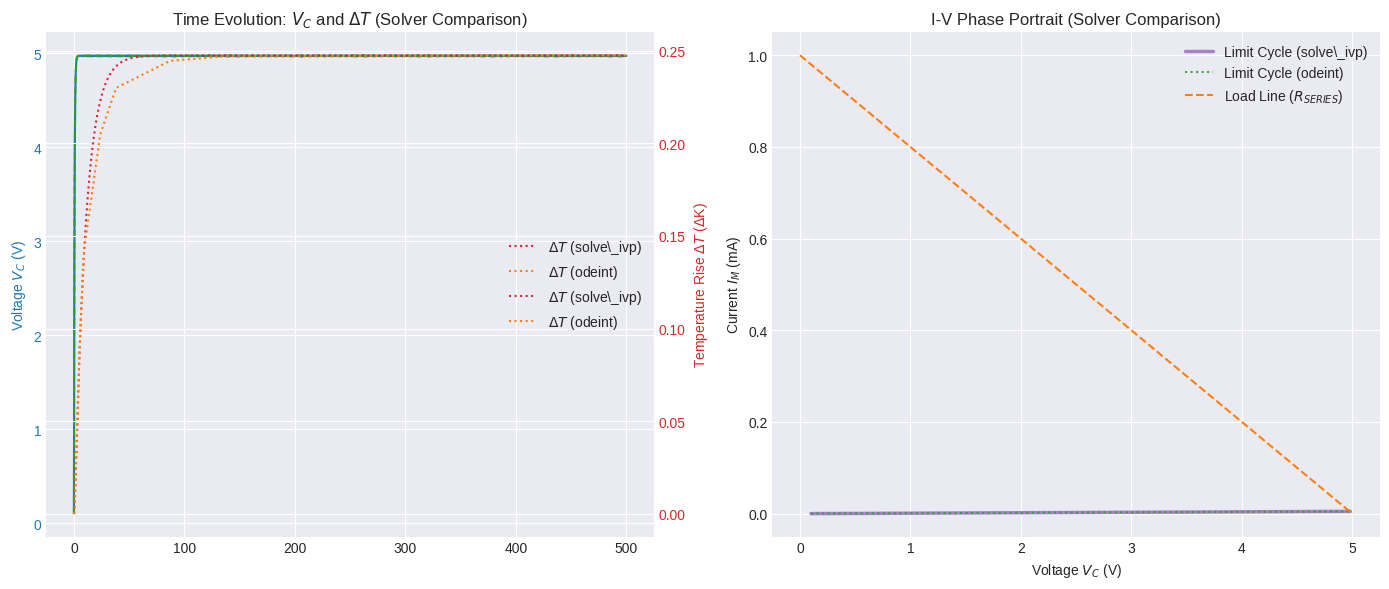


--- Simulation Summary ---
Solver Comparison (Min/Max V_C):
solve_ivp: 0.100 V to 4.981 V
odeint:    0.100 V to 4.975 V

Solver Comparison (Min/Max T):
solve_ivp: 300.0 K to 300.2 K
odeint:    300.0 K to 300.2 K

NDR device must have an S-type characteristic for these parameters to oscillate.


In [5]:
import numpy as np
from scipy.integrate import solve_ivp, odeint # Added odeint
import matplotlib.pyplot as plt

# --- 1. Circuit and Model Parameters ---

# Circuit parameters (External components)
V_BIAS = 5.0    # DC Supply Voltage (Volts)
R_SERIES = 5e3  # Series Load Resistor (Ohms). Must be large enough to enable NDR operation.
C_CAP = 100e-9  # External Capacitor (Farads). Provides the slow voltage dynamics.

# Thermal NDR Model Parameters (Device parameters)
T_AMB = 300.0   # Ambient Temperature (Kelvin)
C_TH = 1e-6     # Thermal Capacitance (J/K)
G_TH = 1e-4     # Thermal Conductance to ambient (W/K) (1/R_th)

# Electrical Conductance Parameters
# This model uses an Arrhenius-like temperature dependence for conductance,
# which is common for oxide-based threshold switches.
G_0 = 1e-6      # Low-temp (leakage) conductance (Siemens)
G_1 = 0.5e-3    # Factor for high-temp conductance (Siemens)
E_A = 0.4       # Activation Energy (eV) - determines sensitivity to temp
K_B = 8.617e-5  # Boltzmann Constant (eV/K)

# --- 2. Defining the System of ODEs (The Derivatives) ---

def electro_thermal_ndr_ode(t, Y):
    """
    Defines the system of two coupled ordinary differential equations (ODEs)
    using the standard (t, Y) signature required by solve_ivp.

    The state vector Y = [V_C, T].
    """
    V_C, T = Y

    # --- Step 1: Calculate the NDR device's dynamic conductance G(T) ---
    try:
        G_M = G_0 + G_1 * np.exp(-E_A / (K_B * T))
    except OverflowError:
        G_M = G_0

    # --- Step 2: Calculate Current and Power ---
    I_M = G_M * V_C  # Current through the NDR device
    P_M = I_M * V_C  # Power dissipated by Joule heating

    # --- Step 3: Calculate the Derivatives ---

    # 1. dV_C/dt (Electrical Circuit Equation - KCL)
    I_R = (V_BIAS - V_C) / R_SERIES
    dV_C_dt = (I_R - I_M) / C_CAP

    # 2. dT/dt (Thermal Equation - Energy Balance)
    P_diss = G_TH * (T - T_AMB)
    dT_dt = (P_M - P_diss) / C_TH

    return np.array([dV_C_dt, dT_dt])

# Function required by odeint (takes Y, then t)
def electro_thermal_ndr_ode_odeint(Y, t):
    """Wrapper function for odeint, swaps (Y, t) arguments to call the main ODE."""
    return electro_thermal_ndr_ode(t, Y)

# Helper function to calculate current from simulated voltage and temperature
def calculate_currents(V_C_array, T_array):
    I_M_array = np.zeros_like(V_C_array)
    for i in range(len(V_C_array)):
        T = T_array[i]
        # Calculate conductance G(T) for each time step
        G_M = G_0 + G_1 * np.exp(-E_A / (K_B * T))
        I_M_array[i] = G_M * V_C_array[i]
    return I_M_array

# --- 3. Simulation Setup and Execution ---

# Initial conditions (V_C and T)
Y0 = np.array([0.1, T_AMB])

# Time span for the simulation
T_SPAN = [0, 0.5] # 0 to 0.5 seconds
T_POINTS = np.linspace(T_SPAN[0], T_SPAN[1], 5000)

print(f"Starting simulation for {T_SPAN[1]} seconds...")

# --- Solve with solve_ivp (RK45) ---
solution_ivp = solve_ivp(
    electro_thermal_ndr_ode,
    T_SPAN,
    Y0,
    t_eval=T_POINTS,
    method='RK45', # Runge-Kutta method for accuracy
    atol=1e-6,
    rtol=1e-3
)

V_C_ivp = solution_ivp.y[0]
T_ivp = solution_ivp.y[1]
t_sim = solution_ivp.t
I_M_ivp = calculate_currents(V_C_ivp, T_ivp)
print("solve_ivp simulation finished.")

# --- Solve with odeint ---
print("\nStarting simulation using odeint...")
Y_odeint = odeint(
    electro_thermal_ndr_ode_odeint, # Use the odeint-compatible wrapper function
    Y0,
    T_POINTS,
    atol=1e-6,
    rtol=1e-3
)

V_C_odeint = Y_odeint[:, 0]
T_odeint = Y_odeint[:, 1]
I_M_odeint = calculate_currents(V_C_odeint, T_odeint)
print("odeint simulation finished. Plotting results.")


# --- 4. Plotting Results ---

plt.style.use('seaborn-v0_8-darkgrid')
plt.figure(figsize=(14, 6))

# --- Plot 1: Voltage and Temperature vs. Time (Comparison) ---
plt.subplot(1, 2, 1)

# Plot solve_ivp voltage (Blue solid)
plt.plot(t_sim * 1000, V_C_ivp, label=r'$V_C$ (solve\_ivp)', color='tab:blue')
# Plot odeint voltage (Green dashed)
plt.plot(t_sim * 1000, V_C_odeint, label=r'$V_C$ (odeint)', color='tab:green', linestyle='--')
plt.ylabel('Voltage $V_C$ (V)', color='tab:blue')
plt.tick_params(axis='y', labelcolor='tab:blue')

# Create a second axis for temperature
ax2 = plt.gca().twinx()
# Plot solve_ivp temperature (Red solid)
ax2.plot(t_sim * 1000, T_ivp - T_AMB, label=r'$\Delta T$ (solve\_ivp)', color='tab:red', linestyle=':')
# Plot odeint temperature (Orange dashed)
ax2.plot(t_sim * 1000, T_odeint - T_AMB, label=r'$\Delta T$ (odeint)', color='tab:orange', linestyle=':')
ax2.set_ylabel(r'Temperature Rise $\Delta T$ ($\Delta$K)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Time Evolution: $V_C$ and $\Delta T$ (Solver Comparison)')
plt.xlabel('Time (ms)')
# Merge legends from both axes
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='center right')


# --- Plot 2: NDR I-V Characteristic (Phase Portrait Comparison) ---
plt.subplot(1, 2, 2)
# Calculate the load line
V_C_load = np.linspace(0, V_BIAS, 100)
I_R_load = (V_BIAS - V_C_load) / R_SERIES

# Plot solve_ivp Limit Cycle
plt.plot(V_C_ivp, I_M_ivp * 1000, label='Limit Cycle (solve\_ivp)', color='tab:purple', linewidth=2.5, alpha=0.8)
# Plot odeint Limit Cycle
plt.plot(V_C_odeint, I_M_odeint * 1000, label='Limit Cycle (odeint)', color='tab:green', linewidth=1.5, linestyle=':', alpha=0.9)

plt.plot(V_C_load, I_R_load * 1000, label=r'Load Line ($R_{SERIES}$)', color='tab:orange', linestyle='--')

plt.title('I-V Phase Portrait (Solver Comparison)')
plt.xlabel('Voltage $V_C$ (V)')
plt.ylabel('Current $I_M$ (mA)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Print Final Oscillation Info ---
print("\n--- Simulation Summary ---")
print("Solver Comparison (Min/Max V_C):")
print(f"solve_ivp: {np.min(V_C_ivp):.3f} V to {np.max(V_C_ivp):.3f} V")
print(f"odeint:    {np.min(V_C_odeint):.3f} V to {np.max(V_C_odeint):.3f} V")

print("\nSolver Comparison (Min/Max T):")
print(f"solve_ivp: {np.min(T_ivp):.1f} K to {np.max(T_ivp):.1f} K")
print(f"odeint:    {np.min(T_odeint):.1f} K to {np.max(T_odeint):.1f} K")

print("\nNDR device must have an S-type characteristic for these parameters to oscillate.")